In [4]:
%config Completer.use_jedi = False

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras

plt.style.use('ggplot')

In [5]:
def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]
def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext

In [6]:
data_file = 'criteo_attribution_dataset.tsv.gz'
df0 = pd.read_csv(data_file, sep='\t', compression='gzip')

n_campaigns = 400

def lta_df(df):
    df0 = df
    df1 = add_derived_columns(df0)
    df2 = sample_campaigns(df1, n_campaigns)
    df3 = filter_journeys_by_length(df2, 2)
    df4 = balance_conversions(df3)
    df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
    df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])
    return df6
df6 = lta_df(df0)
print(df6.shape[0])
print([df6[df6.conversion == 0].shape[0], df6[df6.conversion == 1].shape[0]])

657713
[330979, 326734]


In [4]:
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df6)

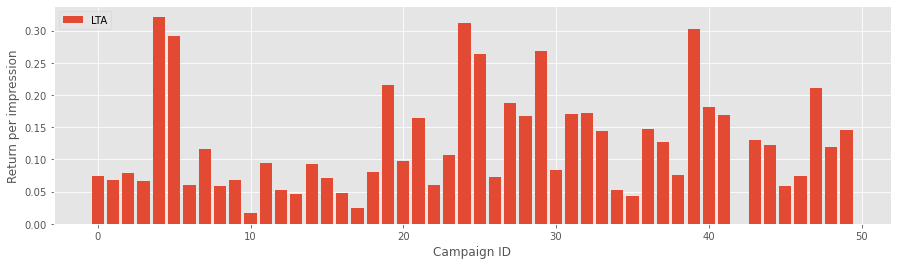

In [5]:
# Visualization of the attribution scores

campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

<html>  <font color = 'blue' size = 4>Logistic Regression 


In [11]:
def features_for_logistic_regression(df):

    def pairwise_max(series):
        return np.max(series.tolist(), axis = 0).tolist()
    
    aggregation = {
        'campaigns': pairwise_max,
        'cats': pairwise_max,
        'click': 'sum',
        'cost': 'sum',
        'conversion': 'max'
    }
    
    df_agg = df.groupby(['jid']).agg(aggregation)
    
    df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()
    
    return (
        np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values),
        df_agg['conversion'].values
    )


In [12]:
x, y = features_for_logistic_regression(df6)
print(np.shape(x))
(145440, 1561)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

# Quick sanity check
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
score = logisticRegr.score(x_test, y_test)
print(score)

(138786, 1567)
0.8594279126738238


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.constraints import NonNeg

m = np.shape(x)[1]
    
model = Sequential()  
model.add(Dense(1, input_dim=m, activation='sigmoid', name = 'contributions')) 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Epoch 1/10
694/694 [==============================] - 3s 3ms/step - loss: 0.5919 - accuracy: 0.6962 - val_loss: 0.4668 - val_accuracy: 0.8083
Epoch 2/10
694/694 [==============================] - 2s 2ms/step - loss: 0.4593 - accuracy: 0.8107 - val_loss: 0.4316 - val_accuracy: 0.8223
Epoch 3/10
694/694 [==============================] - 2s 2ms/step - loss: 0.4281 - accuracy: 0.8257 - val_loss: 0.4134 - val_accuracy: 0.8295
Epoch 4/10
694/694 [==============================] - 2s 2ms/step - loss: 0.4097 - accuracy: 0.8336 - val_loss: 0.4018 - val_accuracy: 0.8349
Epoch 5/10
694/694 [==============================] - 1s 2ms/step - loss: 0.4004 - accuracy: 0.8385 - val_loss: 0.3936 - val_accuracy: 0.8379
Epoch 6/10
694/694 [==============================] - 2s 2ms/step - loss: 0.3917 - accuracy: 0.8422 - val_loss: 0.3883 - val_accuracy: 0.8394
Epoch 7/10
694/694 [==============================] - 2s 2ms/step - loss: 0.3865 - accuracy: 0.8433 - val_loss: 0.3828 - val_accuracy: 0.8418
Epoch 

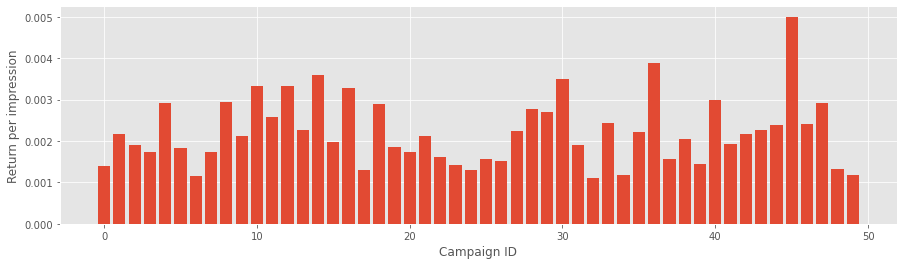

In [14]:
# Visualization of the attribution scores
from sklearn.utils.extmath import softmax

keras_logreg = model.get_layer('contributions').get_weights()[0].flatten()[0:n_campaigns]
keras_logreg = softmax([keras_logreg]).flatten()

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(keras_logreg[campaign_idx])), keras_logreg[campaign_idx] )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.show()

<html><font color = 'blue' size = 4> First Touch Attribute

In [7]:
def fta(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
fta = fta(df6)

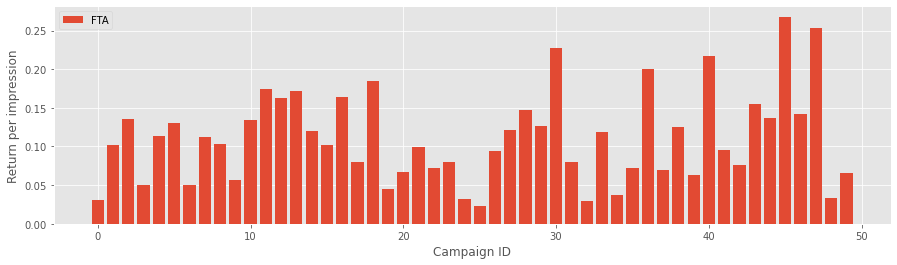

In [10]:
campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(fta[campaign_idx])), fta[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

<html><font color = 'blue' size = 4> Linear Model

In [48]:
def linear_model(df):
    df6 = df
    df_conv = df6.copy()#df6[df6['uid'].isin(df6[df6['conversion'] == 1].uid.unique())]
    # Creating a dataframe conatinng the total count of each campaigin in a particualr jid
    df_count = df_conv.groupby('jid')['campaign'].nunique().reset_index(name = 'count')
    # groupby jid and campaign to merge with count data frame later
    df_t = df_conv.groupby(['jid', 'campaign']).size().reset_index(name='Freq')#.sort_values(by = 'jid')
    df_merge = pd.merge(df_count,df_t)
    # Identifying each indivudal campaign weights
    df_merge['linear_weights'] = 1/df_merge['count']
    # creating a final data frame consisting of weights from individual campaigns 
    linear_df = df_merge.groupby('campaign')['linear_weights'].agg('sum').reset_index(name = 'weight')
    totalCampaign = df6.groupby(['campaign'])['campaign'].count().reset_index(name = 'count')
    linear_df = pd.merge(totalCampaign, linear_df)
    linear_model = np.array(linear_df['weight']/linear_df['count'])
    return linear_model

In [49]:
lm = linear_model(df6)

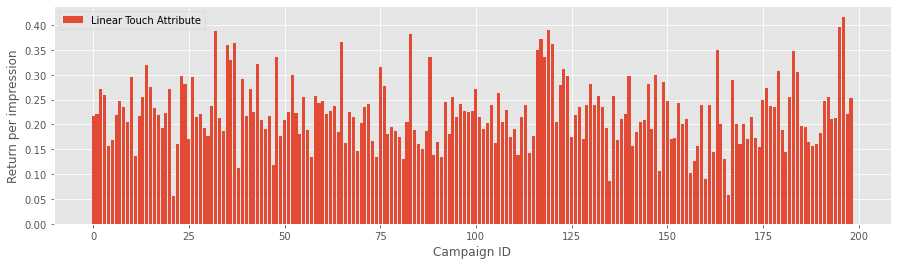

In [50]:
campaign_idx = range(1, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lm[campaign_idx])), lm[campaign_idx], label='Linear Touch Attribute' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

<html><font color = 'blue' size = 4> U Shape Attribute Model

In [47]:
def uShapeAttri(df):
    df6 = df
    df_conv = df6.copy() #df6[df6['uid'].isin(df6[df6['conversion'] == 1].uid.unique())]
    idx1 = df_conv.groupby(['jid'])['timestamp_norm'].transform(min)
    idx2 = df_conv.groupby(['jid'])['timestamp_norm'].transform(max) 
    df1 = df_conv[df_conv['timestamp_norm'].isin(idx2)]
    df2 = df_conv[df_conv['timestamp_norm'].isin(idx2)]
    df1 = pd.concat([df1,df2])
    df1['weight'] = .20
    df1 = df1[['jid', 'campaign', 'weight']]
    ### Creating a data frame for the middle camapigns in each jid 
    df2 = df_conv[~df['timestamp_norm'].isin(idx2)]
    df_count = df2.groupby('jid')['campaign'].nunique().reset_index(name = 'count')
    df_t = df2.groupby(['jid', 'campaign']).size().reset_index(name='Freq')
    df_merge = pd.merge(df_count,df_t)
    # Identifying each indivudal campaign weights
    df_merge['weight'] = 0.6/df_merge['count']
    df_merge = df_merge[['jid', 'campaign','weight']]
    # Concating the dataframe for both First and Last touch points weights with the middle weight 
    df = pd.concat([df1,df_merge]) 
    return df

uDf = uShapeAttri(df6)
uDf = uDf.groupby('campaign')['weight'].agg('sum').reset_index(name = 'weight')
# Creating the total campaign data frame
totalCampaign = df6.groupby(['campaign'])['campaign'].count().reset_index(name = 'count')
uDf = pd.merge(totalCampaign, uDf)
# Creating final utouch model 
uTouchModel = np.array(uDf['weight']/uDf['count'])

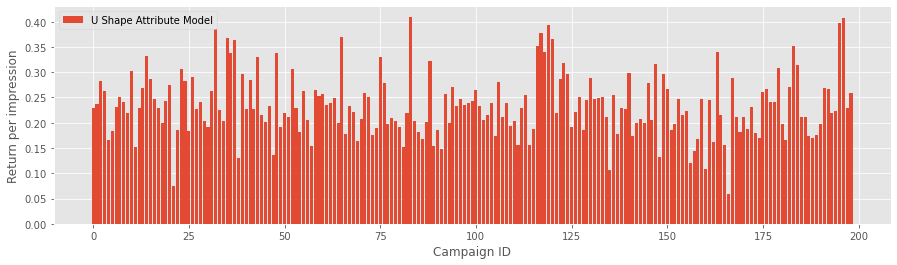

In [38]:
campaign_idx = range(1, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(uTouchModel[campaign_idx])), uTouchModel[campaign_idx], label='U Shape Attribute Model' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

<html><font color = 'blue' size = 4> Time decay attribution model

In [205]:
(df6.days_time / 86400.).apply(int)

267617     0
534865     0
469512     0
425058    16
533662     0
          ..
345169    23
497565   -30
542373    22
527319    10
249121    22
Name: days_time, Length: 565577, dtype: int64

In [206]:
df6['days_time'] = df6['conversion_timestamp'] - df6['timestamp']
df6['days'] = (df6.days_time / 86400.).apply(int)

timedf = df6[['uid', 'campaign', 'conversion','conversion_id','click', 'timestamp_norm', 'jid','days']]

df_converted = timedf[timedf['conversion'] == 1]
df_converted['timedecay'] = df_converted['days'].transform(lambda x: 2**(-x/7))

tdf = df_converted.groupby('campaign')['timedecay'].agg('sum').reset_index(name = 'weight')

timedecay = pd.merge(totalCampaign, tdf, how = 'left')
timedecay.weight = timedecay.weight.fillna(0)
timedecay = np.array(timedecay['weight']/timedecay['count'])

In [207]:
timedecay[1:10]

array([0.13894055, 0.22709578, 0.32954269, 0.19612222, 0.16466987,
       0.15545406, 0.26369583, 0.13674497, 0.1167095 ])

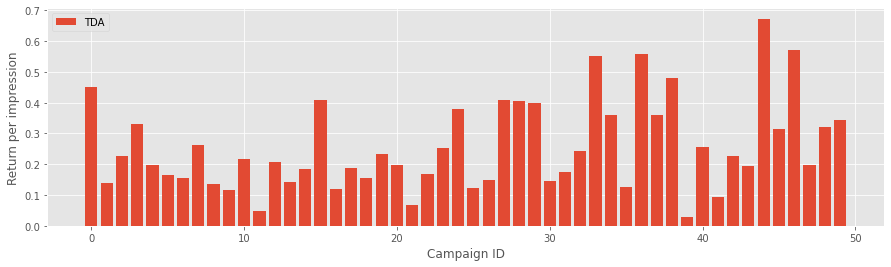

In [208]:
campaign_idx = range(0, 50)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(timedecay[campaign_idx])), timedecay[campaign_idx], label='TDA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()